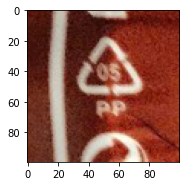

In [22]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

resolution = [100,100, 3]

source_dir = 'datasets'



def plot_img(img_matrix):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    
    ax1.imshow(img_matrix.astype('uint8'))

    plt.show()

def get_result(prediction):
    return np.argmax(prediction)

def get_matrix_data(data, resolution, num):

    x_data = []

    for img in data:

        img_tmp = Image.open(f'{source_dir}/{int(num)}/{img}').resize((resolution[0],resolution[1]))
        img_matrix = np.array(img_tmp).astype('uint8')
        
        x_data.append(img_matrix)
    
    return x_data

def transfrom_data(ratio, source_dir, resolution):

    tmp_train_x = []
    tmp_valid_x = []
    tmp_test_x = []

    train_dataset_x = np.array([])
    valid_dataset_x = np.array([])
    test_dataset_x = np.array([])

    train_dataset_y = np.array([])
    valid_dataset_y = np.array([])
    test_dataset_y = np.array([])

    for nums in  os.listdir(source_dir):

        actual_num  = np.float(nums.split('_')[0])
        
        data = os.listdir(source_dir + '/' + nums)

        # for random take test, train and valid data
        random.shuffle(data)
        
        tmp_train_x.extend(get_matrix_data(data[:int(len(data) * ratio[0])], resolution, actual_num))
        train_dataset_y = np.append(train_dataset_y, np.full((1, int(len(data) * ratio[0])), actual_num))

        tmp_valid_x.extend(get_matrix_data(data[int(len(data) * ratio[0]): int(len(data) * (ratio[0] + ratio[1]))], resolution, actual_num))
        valid_dataset_y = np.append(valid_dataset_y, np.full((1, int(len(data) * (ratio[0] + ratio[1])) - int(len(data) * ratio[0])), actual_num))

        tmp_test_x.extend(get_matrix_data(data[-int(len(data) * ratio[2]):], resolution, actual_num))
        test_dataset_y = np.append(test_dataset_y, np.full((1, int(len(data) * ratio[2])), actual_num))

    train_dataset_x = np.append(train_dataset_x, tmp_train_x)
    train_dataset_x = train_dataset_x.reshape((train_dataset_y.shape[0], resolution[0],resolution[1], 3))

    valid_dataset_x = np.append(valid_dataset_x, tmp_valid_x)
    valid_dataset_x =  valid_dataset_x.reshape((valid_dataset_y.shape[0], resolution[0],resolution[1], 3))

    test_dataset_x = np.append(test_dataset_x ,tmp_test_x)
    test_dataset_x = test_dataset_x.reshape((test_dataset_y.shape[0], resolution[0],resolution[1], 3))

    return {'x': train_dataset_x, 'y': train_dataset_y}, {'x': valid_dataset_x, 'y': valid_dataset_y}, {'x': test_dataset_x, 'y': test_dataset_y}
            
train, valid, test = transfrom_data([0.8, 0.1, 0.1], source_dir, resolution)

plot_img(train['x'][1000])


In [23]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_circles, make_moons, make_blobs
from matplotlib import pyplot as plt
import numpy as np
import gzip
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D
from keras import backend as K



base_model = keras.applications.xception.Xception(weights="imagenet", 
                                                  include_top=False, 
                                                  input_shape=(resolution[0], resolution[1], 3))

In [24]:
#freeze the base model 
base_model.trainable = False
#define the type of NN architecture - sequential model specifies a linear stack of layers 
model = keras.models.Sequential()
#add the pre-trained model
model.add(base_model)

In [25]:
#pool layer to prepare data as input into dense layer 
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(256, activation='relu'))
#batch normalization layer re-centers and re-scales the network - helps accelerate training
model.add(keras.layers.BatchNormalization())
#dropout layer - temporarily deactivates 20% of the nodes in the network each epoch to redistribute weights/help network concentrate on "weak" features and prevent overfitting
model.add(keras.layers.Dropout(0.2))
#flatten layer to single array for input into dense layer 
model.add(keras.layers.Flatten())
# prediction layer - 6 neurons = 6 category outputs, and softmax to normalize the output of the network to a probability distribution over the predicted output classes 
model.add(keras.layers.Dense(8, activation='softmax'))

In [26]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [27]:
history = model.fit(train['x'], train['y'], epochs=40, 
                    validation_data = (valid['x'], valid['y']))

Epoch 1/40
289/289 [==============================] - 136s 470ms/step - loss: 1.1100 - accuracy: 0.6380 - val_loss: 0.8371 - val_accuracy: 0.7264
Epoch 2/40
289/289 [==============================] - 149s 514ms/step - loss: 0.7629 - accuracy: 0.7499 - val_loss: 0.8050 - val_accuracy: 0.7186
Epoch 3/40
289/289 [==============================] - 152s 525ms/step - loss: 0.6784 - accuracy: 0.7848 - val_loss: 0.7233 - val_accuracy: 0.7550
Epoch 4/40
289/289 [==============================] - 141s 487ms/step - loss: 0.6248 - accuracy: 0.8009 - val_loss: 0.6768 - val_accuracy: 0.7948
Epoch 5/40
289/289 [==============================] - 153s 530ms/step - loss: 0.5823 - accuracy: 0.8169 - val_loss: 0.6721 - val_accuracy: 0.7983
Epoch 6/40
171/289 [================>.............] - ETA: 57s - loss: 0.5535 - accuracy: 0.8235

In [ ]:
prediction = cnn.predict(test_dataset_x[42].reshape(-1, 100, 100, 3))
prediction